# Sentiment Analysis

We will explore whether we can use sentiment analysis to help our model, and whether existing sentiment analyzers can even be applied to these medical-related texts.

In [68]:
merged = pd.read_csv('../../DataPlus/feature_dataframe.csv')

## Processed Text Dataframe

In [94]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import Preprocessing as pre
import CompilingCorpus as cc

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
PROCESS_PIPELINE = [
    pre.remove_non_alpha,
    pre.remove_parentheses,
    pre.make_lowercase,
    pre.remove_stopwords,
    pre.lemmatize
]

In [106]:
# creates dataframe with processed text
def process_text_df(df, create=False):
    df = df.copy()
    
    processed_col = []
    for convo in tqdm(df['Convo_1']):
        if isinstance(convo, str):
            processed_convo = cc.untokenize(pre.text_preprocessing(convo, PROCESS_PIPELINE))
            processed_col.append(processed_convo)
        else:
            processed_col.append(np.nan)
    df['Convo_1'] = processed_col
    
    # creates new CSV if create=True
    if create:
        df.to_csv('../../DataPlus/processed_text_df.csv')
        
    return df

In [107]:
# text_df = process_text_df(merged, create=True)

## NLTK SentimentAnalyzer

In [73]:
from random import shuffle
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn.model_selection import train_test_split

In [74]:
def sentiment_classifier(df):
    df = df.copy()
    
    # prepping data
    df = df[['txgot_binary', 'Convo_1']].dropna()
    text_process_col = pre.process_corpus(np.asarray(df['Convo_1']), [])
    txgot_col = np.asarray(df['txgot_binary'])
    
    # turns into list of tuples (convo, label)
    docs = list(zip(text_process_col, txgot_col))
    shuffle(docs)
    training_docs = docs[:int(len(docs) * 2 / 3)]
    test_docs = docs[int(len(docs) * 2 / 3):]
    
    # sentiment analyzer
    sentim_analyzer = SentimentAnalyzer()
    
    # simple unigram word features, handling negation
    all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])
    unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
    sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)
    
    # train classifier
    training_set = sentim_analyzer.apply_features(training_docs)
    test_set = sentim_analyzer.apply_features(test_docs)
    trainer = NaiveBayesClassifier.train
    classifier = sentim_analyzer.train(trainer, training_set)
    
    # show results
    for key, value in sentim_analyzer.evaluate(test_set).items():
        print('{}: {}'.format(key, value))

In [76]:
sentiment_classifier(merged)

HBox(children=(IntProgress(value=0, max=356), HTML(value='')))


Training classifier
Evaluating NaiveBayesClassifier results...
Accuracy: 0.6050420168067226
Precision [0.0]: 0.76
Recall [0.0]: 0.5205479452054794
F-measure [0.0]: 0.6178861788617885
Precision [1.0]: 0.4927536231884058
Recall [1.0]: 0.7391304347826086
F-measure [1.0]: 0.591304347826087


## Vader

In [81]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\grant\AppData\Roaming\nltk_data...


In [118]:
"""
    input: dataframe (merged)
    output: dataframe with new columns for sentiment scores
"""
def vader_sentiment(df, create=False):
    df = df.copy()
    
    sid = SentimentIntensityAnalyzer()
    
    # arrays for each sentiment metric
    compound_sentiment = []
    neg_sentiment = []
    neutral_sentiment = []
    pos_sentiment = []
    
    for doc in tqdm(df['Convo_1']):
        if not isinstance(doc, str):
            compound_sentiment.append(np.nan)
            neg_sentiment.append(np.nan)
            neutral_sentiment.append(np.nan)
            pos_sentiment.append(np.nan)
        else:
            ss = sid.polarity_scores(doc)
            compound_sentiment.append(ss['compound'])
            neg_sentiment.append(ss['neg'])
            neutral_sentiment.append(ss['neu'])
            pos_sentiment.append(ss['pos'])
    
    # add columns to dataframe
    df['vader_compound'] = compound_sentiment
    df['vader_neg'] = neg_sentiment
    df['vader_neutral'] = neutral_sentiment
    df['vader_pos'] = pos_sentiment
    
    return df

In [119]:
vader_df = vader_sentiment(merged)

HBox(children=(IntProgress(value=0, max=465), HTML(value='')))

### Sentiment Visualization

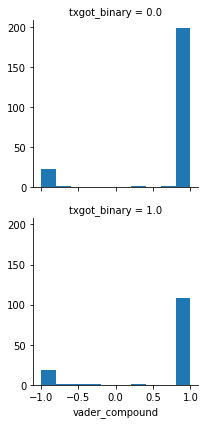

In [123]:
comp_sent_face = sns.FacetGrid(vader_df, row="txgot_binary")
comp_sent_face = comp_sent_face.map(plt.hist, "vader_compound")

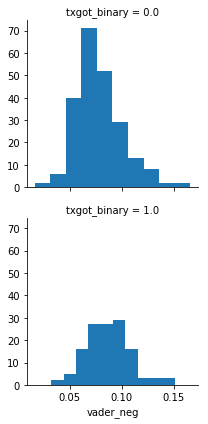

In [124]:
neg_sent_face = sns.FacetGrid(vader_df, row="txgot_binary")
neg_sent_face = neg_sent_face.map(plt.hist, "vader_neg")

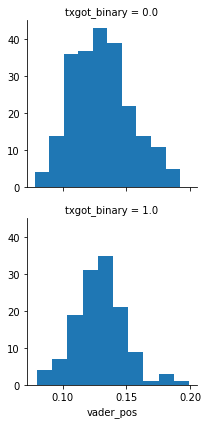

In [125]:
pos_sent_face = sns.FacetGrid(vader_df, row="txgot_binary")
pos_sent_face = pos_sent_face.map(plt.hist, "vader_pos")

In [126]:
vader_df.groupby('txgot_binary').mean()[['vader_compound', 'vader_neg', 'vader_neutral', 'vader_pos']]

,vader_compound,vader_neg,vader_neutral,vader_pos
txgot_binary,,,,
0.0,0.774075,0.079084,0.790716,0.130178
1.0,0.669327,0.087092,0.783710,0.129130


## Vader with Text Preprocessing

In [127]:
process_text_df = pd.read_csv('../../DataPlus/processed_text_df.csv')

In [128]:
processed_vader_df = vader_sentiment(process_text_df)

HBox(children=(IntProgress(value=0, max=465), HTML(value='')))

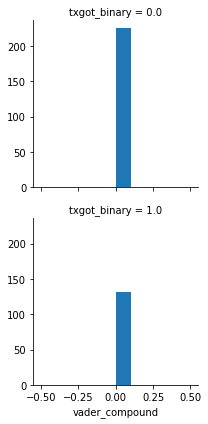

In [129]:
comp2_sent_face = sns.FacetGrid(processed_vader_df, row="txgot_binary")
comp2_sent_face = comp2_sent_face.map(plt.hist, "vader_compound")

It looks like Vader sentiment analysis does not work with preprocessed text.

## TextBlob Sentiment

In [130]:
from textblob import TextBlob

In [135]:
def textblob_sentiment(df, create=False):
    df = df.copy()
    
    polarity = []
    subjectivity = []
    
    for doc in tqdm(df['Convo_1']):
        if not isinstance(doc, str):
            polarity.append(np.nan)
            subjectivity.append(np.nan)
        else:
            blob = TextBlob(doc)
            sentiment = blob.sentiment
            polarity.append(sentiment[0])
            subjectivity.append(sentiment[1])
    
    df['blob_polarity'] = polarity
    df['blob_subjectivity'] = subjectivity
    
    return df

In [136]:
blob_df = textblob_sentiment(merged)

HBox(children=(IntProgress(value=0, max=465), HTML(value='')))

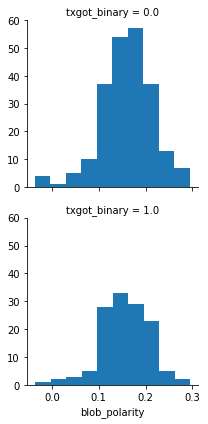

In [138]:
pol_face = sns.FacetGrid(blob_df, row="txgot_binary")
pol_face = pol_face.map(plt.hist, "blob_polarity")

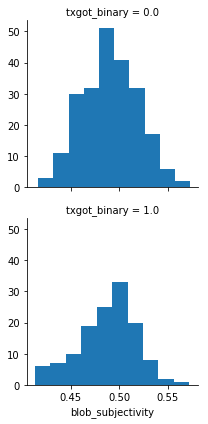

In [140]:
subj_face = sns.FacetGrid(blob_df, row="txgot_binary")
subj_face = subj_face.map(plt.hist, "blob_subjectivity")

In [141]:
blob_df.groupby('txgot_binary').mean()[['blob_polarity', 'blob_subjectivity']]

,blob_polarity,blob_subjectivity
txgot_binary,,
0.0,0.160395,0.490694
1.0,0.155692,0.487424
